# TensorFlow to PyTorch: CNN for Text Classification

This notebook is the PyTorch equivalent of the original TensorFlow/Keras notebook. 

The key differences are:
1.  **Model Definition**: PyTorch uses a class-based `nn.Module` to define the model architecture.
2.  **Data Handling**: PyTorch uses `Dataset` and `DataLoader` to prepare and batch the data for training.
3.  **Training Loop**: PyTorch requires an explicit training and validation loop to be written, whereas Keras abstracts this with the `.fit()` method.
4.  **Tensor Shapes**: PyTorch's `nn.Conv1d` layer expects the input shape to be `(batch_size, embedding_dim, sequence_length)`, which requires permuting the tensor dimensions after the embedding layer.

### 1. Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import copy

/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mahas/PycharmProjects/STIRS/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Setting up Parameters and Loading Data

In [2]:
# Setting up the parameters
maximum_features = 30522  # Vocabulary size for BERT
maximum_length = 128      # Max length of input sequences
word_embedding_dims = 50  # Dimension of word embeddings (Note: In PyTorch this is embedding_dim)
no_of_filters = 128       # Number of filters for Conv1D
kernel_size = 3           # Size of the convolutional kernel
hidden_dim_1 = 128        # Neurons in the dense hidden layer

batch_size = 64
epochs = 10
threshold = 0.5
DATASET_SIZE = 100_000

# Load and preprocess the dataset
# Make sure the path to your CSV is correct
df = pd.read_csv("../jigsaw/dataset_text_target.csv")
df_true = df[df.target > 0.5]
df_false = df[df.target <= 0.5]
df = pd.concat([df_true[:DATASET_SIZE//2], df_false[:DATASET_SIZE//2]], axis=0)
mapper = lambda x: 1 if x > 0.5 else 0
df['target'] = df['target'].apply(mapper)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    df.comment_text, df.target, test_size=0.2, random_state=42, shuffle=True
)

### 3. Tokenization and Data Preparation
Here, we tokenize the text with the BERT tokenizer but set `return_tensors='pt'` for PyTorch tensors. We then create `TensorDataset` and `DataLoader` objects to handle batching.

In [3]:
# Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encode the training and test data
X_train_encoded = tokenizer.batch_encode_plus(
    x_train.tolist(),
    padding='max_length',
    truncation=True,
    max_length=maximum_length,
    add_special_tokens=True,
    return_tensors='pt',  # Return PyTorch tensors
)

X_test_encoded = tokenizer.batch_encode_plus(
    x_test.tolist(),
    padding='max_length',
    truncation=True,
    max_length=maximum_length,
    add_special_tokens=True,
    return_tensors='pt', # Return PyTorch tensors
)

# Create PyTorch Datasets
train_dataset = TensorDataset(X_train_encoded['input_ids'], torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(X_test_encoded['input_ids'], torch.tensor(y_test.values, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 4. Building the PyTorch Model

We define the CNN architecture as a class inheriting from `torch.nn.Module`. Note the use of `.permute(0, 2, 1)` to make the tensor shape compatible with `nn.Conv1d`.

In [5]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_size, hidden_dim):
        super(CNNTextClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Convolutional layers
        self.conv1 = nn.Conv1d(embedding_dim, n_filters, kernel_size=filter_size, padding='valid')
        self.pool1 = nn.MaxPool1d(kernel_size=3)

        self.conv2 = nn.Conv1d(n_filters, n_filters, kernel_size=filter_size, padding='valid')
        self.pool2 = nn.MaxPool1d(kernel_size=3)

        self.conv3 = nn.Conv1d(n_filters, n_filters, kernel_size=filter_size, padding='valid')
        # Global Max Pooling is achieved with AdaptiveMaxPool1d
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # Dense layers
        self.fc1 = nn.Linear(n_filters, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)


    def forward(self, input_ids):
        # input_ids shape: (batch_size, seq_len)
        embedded = self.embedding(input_ids)
        # embedded shape: (batch_size, seq_len, embedding_dim)

        # PyTorch Conv1d expects (batch_size, channels, seq_len)
        # So we permute the dimensions
        embedded = embedded.permute(0, 2, 1)

        x = self.pool1(F.relu(self.conv1(embedded)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        x = self.global_pool(x).squeeze(2) # Squeeze to remove the last dimension

        x = F.relu(self.fc1(x))
        output = torch.sigmoid(self.fc2(x))

        return output

# Instantiate the model
model = CNNTextClassifier(
    vocab_size=maximum_features,
    embedding_dim=word_embedding_dims,
    n_filters=no_of_filters,
    filter_size=kernel_size,
    hidden_dim=hidden_dim_1
)

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

CNNTextClassifier(
  (embedding): Embedding(30522, 50)
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (global_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


### 5. Training the Model

We define the loss function and optimizer, then write an explicit loop to train the model over 10 epochs and validate its performance.

In [6]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters())

# To store history
history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())


for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for input_ids, labels in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > threshold).int()
        total_train += labels.size(0)
        correct_train += (predicted == labels.int()).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for input_ids, labels in test_loader:
            input_ids, labels = input_ids.to(device), labels.to(device).unsqueeze(1)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = (outputs > threshold).int()
            total_val += labels.size(0)
            correct_val += (predicted == labels.int()).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    
    # Save history
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/10 | Train Loss: 0.4539 | Train Acc: 0.7665 | Val Loss: 0.3004 | Val Acc: 0.8749
Epoch 2/10 | Train Loss: 0.2589 | Train Acc: 0.8961 | Val Loss: 0.2707 | Val Acc: 0.8884
Epoch 3/10 | Train Loss: 0.2074 | Train Acc: 0.9206 | Val Loss: 0.2582 | Val Acc: 0.8949
Epoch 4/10 | Train Loss: 0.1730 | Train Acc: 0.9347 | Val Loss: 0.2643 | Val Acc: 0.8988
Epoch 5/10 | Train Loss: 0.1446 | Train Acc: 0.9471 | Val Loss: 0.2539 | Val Acc: 0.9019
Epoch 6/10 | Train Loss: 0.1164 | Train Acc: 0.9584 | Val Loss: 0.2866 | Val Acc: 0.8983
Epoch 7/10 | Train Loss: 0.0934 | Train Acc: 0.9674 | Val Loss: 0.3199 | Val Acc: 0.8932
Epoch 8/10 | Train Loss: 0.0712 | Train Acc: 0.9760 | Val Loss: 0.3456 | Val Acc: 0.8949
Epoch 9/10 | Train Loss: 0.0573 | Train Acc: 0.9806 | Val Loss: 0.4259 | Val Acc: 0.8914
Epoch 10/10 | Train Loss: 0.0465 | Train Acc: 0.9846 | Val Loss: 0.4267 | Val Acc: 0.8911


<All keys matched successfully>

### 6. Evaluating the Model

In [7]:
model.eval()
y_pred_prob = []
y_true = []

with torch.no_grad():
    for input_ids, labels in test_loader:
        input_ids = input_ids.to(device)
        outputs = model(input_ids).squeeze()
        y_pred_prob.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = (np.array(y_pred_prob) > threshold).astype(int)

# Calculating and printing evaluation metrics
print('\nEvaluation Metrics:')
print('Accuracy:', accuracy_score(y_true, y_pred))
print('Precision:', precision_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('F1-score:', f1_score(y_true, y_pred))
print('\nClassification Report:')
print(classification_report(y_true, y_pred))


Evaluation Metrics:
Accuracy: 0.9019
Precision: 0.8938433017855401
Recall: 0.9129048330842053
F1-score: 0.9032735160717807

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      9965
         1.0       0.89      0.91      0.90     10035

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



### 7. Plotting Results

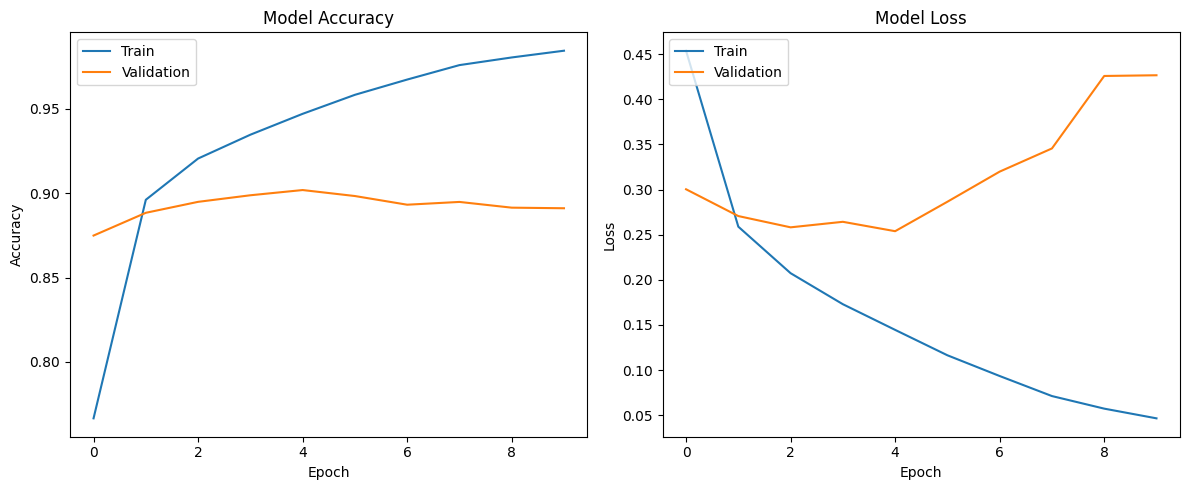

In [8]:
# Plotting Model Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Plotting Model Loss
plt.subplot(1, 2, 2)
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

plt.tight_layout()
plt.show()

### 8. Saving the Model

Finally, we can save the trained model's state dictionary for later use.

In [9]:
torch.save(model.state_dict(), "../cnn_model_trained_torch/cnn_model_trained_pytorch.pth")
print("Model saved to cnn_model_trained_pytorch.pth")

Model saved to cnn_model_trained_pytorch.pth
